In [129]:
%matplotlib inline
import cortx_community as cc
import cortx_graphing as cg
import datetime
import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint, pformat
from IPython.display import Markdown, display, Pretty, Latex, HTML
from wordcloud import WordCloud, STOPWORDS
import matplotlib.dates as mdates

# default graph size.  Not sure this is needed.
plt.rcParams['figure.figsize'] = [20, 5]

In [130]:
## THIS CELL JUST CONTAINS FUNCTIONS WHICH ARE USED ELSEWHERE

def get_external_domains_wordcloud():
    domain_cloud=''
    people=cc.CortxCommunity()
    #print('Total people is %d' % len(people.items()))
    stopwords=set()
    stopwords.update(['hotmail','outlook','icloud','gmail','ac','co','yahoo','fz','mail','pm','calsoftinc','msystechnologies'])
    stopwords.update(['ed'])
    for login,person in people.items():
        email = person.get_email()
        if email and 'seagate' not in email and 'gmail' not in email:
            try:
                domain_cloud += email.split('@')[1].replace('.','-') + " "
                stopwords.add(email.split('.')[-1]) # remove final domains
            except IndexError:
                #print("Couldn't get domain from %s" % email)
                pass
    #print(domain_cloud)
    #print(stopwords)
    return (domain_cloud,stopwords)
    
def plot_cloud(wordcloud,caption=None):
    # Set figure size
    plt.figure(figsize=(20, 8))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off")
    if caption:
        add_caption(plt,caption)
    plt.show()

def get_domains(ps):
    (a,b)=ps.get_latest(repo)
    dates=ps.get_dates(repo)
    current_domains=a['domains']
    try:
        current_domains|=a['slack_members_domains']
    except KeyError:
        pass # slack scrape hasn't run yet
    #print(domains)
    #print(dates)
    closest_date=None
    closest_distance=None
    month_ago=datetime.datetime.utcnow() - datetime.timedelta(days=+30)
    today=datetime.datetime.utcnow().strftime("%m/%d/%Y")
    #print(month_ago)
    all_domains=[] # also create a list of every domains for each date, used by another graph later
    for date in dates:
        pdd = pd.to_datetime(date)
        distance = abs((month_ago-pdd).days)
        if closest_date is None:
            closest_date = date
            closest_distance = distance
        if distance < closest_distance:
            closest_distance = distance
            closest_date = date
        all_domains.append(ps.get_values(repo,'domains',[date])[0])
        try:
            all_domains[-1] |= ps.get_values(repo,'slack_members_domains',[date])[0]
        except TypeError:
            pass # didn't always have slack data
        try:
            all_domains[-1]=len(all_domains[-1])
        except TypeError:
            all_domains[-1]=0 # could have been none
    #print("The date closest to one month ago is %s" % closest_date)
    month_ago_domains=ps.get_values(repo,'domains',[closest_date])[0]
    try:
        month_ago_domains |= ps.get_values(repo,'slack_members_domains',[closest_date])[0]
    except TypeError:
        pass # we maybe didn't have slack data a month
    #pprint(current_domains)
    #pprint(month_ago_domains)
    new_domains=current_domains-month_ago_domains
    #pprint(new_domains)
    #print(len(month_ago_domains),len(current_domains),len(current_domains-month_ago_domains))
    return(current_domains,new_domains,all_domains)

# I think this function isn't being used anywhere so we can drop it later
def remove_date(df,date):
    try:
        df=df.drop(pd.to_datetime(date),axis=0) # this first scrape was no good, double counted issues and pulls
    except KeyError:
        pass # was already dropped
    return df

def nice_slack_title(ugly):
    return ugly.replace('_', ' ').replace('slack ','').title()

def external_graph(Activity,goal_value,caption=None,rectangle=True):
    title=('Total External %s' % Activity).title()
    types=['hackathon','innersource','external', 'eu_r&d']
    local_df = df
    local_df = local_df.fillna(0)
    local_df[title]=0
    columns=[title]
    for t in types:
        column = '%s_%s' % (t,Activity)
        local_df[title] += local_df[column]
        if t == 'external':
            local_df['unaffiliated_%s' % Activity] = local_df[column]
            columns.append('unaffiliated_%s' % Activity)
        else:
            columns.append(column)
    # make the column names look better
    newcolumns=[]
    for column in columns:
        pretty_name = column.replace('_%s' % Activity, '').title().replace('_',' ')
        if 'Eu' in pretty_name:
            pretty_name.replace('Eu','EU')
        if 'Total' in pretty_name:
            pretty_name = 'TOTAL'
        newcolumns.append(pretty_name)
        local_df[pretty_name]=local_df[column]
    #local_df.replace(np.nan, 0)
    goal=cg.Goal(title,goal_date,goal_value)
    plt=cg.goal_graph(df=local_df,title=title,xlim=(None,goal_date),goals=[goal],columns=newcolumns)
    if caption:
        add_caption(plt,caption)
    plt.legend(loc='upper left')
    if rectangle:
        plt=add_date_rectangle(plt)
    plt.show()
    
def get_sf_dataframe(data):
    def add_items_to_df(df,name,items):
        df1=pd.DataFrame(data={name : items})
        return pd.concat([df, df1], axis=1) 
    
    largest=0
    name_of_largest = None
    for k,v in data.items():
        if len(v[1]) > largest:
            largest = len(v[1])
            name_of_largest = k
    df=pd.DataFrame(index=data[name_of_largest][0],data={ name_of_largest : data[name_of_largest][1] })
    for k,v in data.items():
        if k is not name_of_largest:
            df=add_items_to_df(df,k,v[1])
    return df

def make_sf_graph(df,data,end_day,title,what,caption,rectangle=True):
    def get_max_y(data):
        max_y=0
        for k,v in data.items():
            try:
                this_max = v[1][end_day]
            except IndexError:
                this_max = v[1][-1]
            max_y = max(max_y,this_max)
        return max_y * 1.1 # increase it by 10% to add some margin at top of graph

    if end_day:
        max_y=get_max_y(data)
    else:
        max_y=None
    ax=df.plot(xlim=(0,end_day),ylim=(0,max_y),title="%s %s Data" % (title,what))
    ax.set_ylabel('%s Count' % what)
    ax.set_xlabel('Day')
    if caption:
        add_caption(plt,caption)
    plt.show()

def make_sf_graph(df,data,end_day,title,what,caption,rectangle=False):
    def get_max_y(data):
        max_y=0
        for k,v in data.items():
            try:
                this_max = v[1][end_day]
            except IndexError:
                this_max = v[1][-1]
            max_y = max(max_y,this_max)
        return max_y * 1.1 # increase it by 10% to add some margin at top of graph

    if end_day:
        max_y=get_max_y(data)
    else:
        max_y=None
    ax=df.plot(xlim=(0,end_day),ylim=(0,max_y),title="%s %s Data" % (title,what))
    ax.set_ylabel('%s Count' % what)
    ax.set_xlabel('Day')
    if caption:
        add_caption(plt,caption)
    if rectangle:
        box_last=df['CORTX'].last_valid_index()
        box_start=box_last-42
        add_rectangle(plt,box_start,42)       
    plt.show()

    
def company_graph(df,Type,caption=None,rectangle=False):
    title='External Companies'
    if Type != 'Both':
        title += ' %s' % Type
    e_title='Companies Participating' 
    c_title='Companies Contributing' 
    df[e_title]=df['all_domains']
    df[c_title]=df['companies_contributing']
    for d in ('2020-12-21', '2020-12-24', '2020-12-26'):
        try:
            df=df.drop(pd.to_datetime(d),axis=0) # bit of an ugly value here which makes graph look bad
        except KeyError:
            pass # might have already been dropped
    columns=[e_title,c_title]
    e_goal=cg.Goal(e_title,goal_date,200)
    c_goal=cg.Goal(c_title,goal_date,20) 
    if Type == 'Both':
        plt1=cg.goal_graph(df=df,title=title,xlim=xlim,goals=[e_goal,c_goal],columns=[e_title,c_title])
    elif Type == 'Participating':
        plt1=cg.goal_graph(df=df,title=title,xlim=xlim,goals=[e_goal],columns=[e_title])
    elif Type == 'Contributing':
        plt1=cg.goal_graph(df=df,title=title,xlim=xlim,goals=[c_goal],columns=[c_title])
    if caption is not None:
        add_caption(plt,caption)
    plt1.legend(loc='upper left')
    if rectangle:
        plt1=add_date_rectangle(plt1)
    plt1.show()

# if we are making an accumulation graph, make sure that we don't have more than one value per week
def remove_overly_frequent(df,threshold=8):
    df1=df # make a copy because we want to remove some values from it
    last_date=None
    removals=[]
    for rid,(date,row) in enumerate(df.iterrows()):
        if last_date is None:
            last_date=date.date()
        this_date = date.date()
        if this_date != last_date and (this_date - last_date).days < threshold:
            #print("need to remove %s" % this_date)
            removals.append(date)
        else:
            last_date = this_date
    #print(removals)
    #print(type(removals))
    df1=df1.drop(removals)
    return(df1)

def add_caption(plt,strings):
    offset=-0.1
    offset_shift=-0.06
    for string in strings:
        plt.figtext(.1, offset, string, size=20)
        offset += offset_shift
        
def collect_summary_graph_data(df):
    def add_login(login,Set,Type,Dict):
        Set.add(login)
        if Type not in Dict:
            Dict[Type]=set()
        Dict[Type].add(login)
    
    external_data = []
    metric0='Viewed'
    metric1='Joined'
    metric2='Engaged'
    metric3='Contributed'
    cmty=cc.CortxCommunity()
    df1=remove_overly_frequent(df[['views_unique_14_days','slack_total_members','slack_member_count']])
    df1[metric0]=df1['views_unique_14_days'].cumsum()
    df1['slack_num_members']=df1[['slack_total_members','slack_member_count']].max(axis=1).fillna(method='ffill')
    all_joiners=[]
    all_engagers=[]
    all_contributors=[]
    for date,row in df1.iterrows():
        joiners=set()
        joiner_groups={} # split by type to get better graphs
        engagers=set()
        engagers_groups={}
        contributors=set()
        contributors_groups={}
        activities=cmty.get_external_activity(until=str(date))
        for login,actions in activities.items():
            Type=cmty.get_type(login)
            for action in actions.values():
                if 'fork ->' or 'starred ->' in action:
                    add_login(login,joiners,Type,joiner_groups)
                if 'slack' in action or '#discussion' in action or '#issuecomment' in action:
                    add_login(login,joiners,Type,joiner_groups)
                    add_login(login,engagers,Type,engagers_groups)
                if 'pull' in action or 'commit' in action:
                    add_login(login,joiners,Type,joiner_groups)
                    add_login(login,engagers,Type,engagers_groups)
                    add_login(login,contributors,Type,contributors_groups)
        all_joiners.append(len(joiners))
        all_engagers.append(len(engagers))
        all_contributors.append(len(contributors))
        external_data.append([joiner_groups,engagers_groups,contributors_groups])

    df1[metric1]=all_joiners
    df1[metric2]=all_engagers
    df1[metric3]=all_contributors
    return (df1,metric1,metric2,metric3,external_data)

# bit ugly. We're passing around arrays and we just need to remember that
# index 0 is joiners
# index 1 is engaged
# index 2 is contributors
def new_external_graph(external_df,external_data,idx,Key,Goal,caption,rectangle=False):
    cmty=cc.CortxCommunity()
    types=cmty.get_external_types()
    data = {}
    for T in types:
        data[T] = []
    for ed in external_data:
        group=ed[idx]
        for T in types:
            try:
                count = len(group[T])
            except KeyError:
                count = 0
            data[T].append(count)
    for k,v in data.items():
        external_df[k]=v
    types = [k for k in cmty.get_external_types() if k != 'External']
    types.append('Unaffiliated')
    external_df['Unaffiliated']=external_df['External']
    external_df['TOTAL']=external_df[Key]
    types=list(types)
    types.insert(0,'TOTAL')
    goal = cg.Goal('TOTAL', goal_date,Goal)
    plt = cg.goal_graph(df=external_df,title="External %s" % Key,xlim=xlim,goals=[goal],columns=types)
    plt.legend(loc='upper left')
    add_caption(plt,caption)
    if rectangle:
        plt=add_date_rectangle(plt)
    plt.show()
    return external_df

def slide_title(title):
    display(Markdown("<h2><center>%s</center></h2>" % title))

def slide_emphasis(txt):
    display(Markdown("<h3><em><b><center>%s</center></b></em></h3>" % txt))
    
def get_rectangle(plt,start_x,start_y,x_size,y_size):
    return plt.Rectangle((start_x,start_y), x_size, y_size, fc='lavender')

def add_rectangle(plt,start_x,x_size):
    top_y=plt.ylim()[1]
    xrange=plt.xlim()[1]-plt.xlim()[0]
    dave_rectangle = get_rectangle(plt,start_x,0,x_size,top_y)
    plt.gca().add_patch(dave_rectangle)
    return plt

def add_date_rectangle(plt):
    start_x=mdates.date2num(datetime.date.today() - datetime.timedelta(days=+42))
    x_size=mdates.date2num(datetime.date.today())-start_x
    return add_rectangle(plt,start_x,x_size)



In [131]:
# GLOBAL VARIABLES
ps=cc.PersistentStats()
goal_date=datetime.datetime(2021,12,31,0,0,0)
repo='GLOBAL'
df=cg.get_dataframe(ps=ps,repo=repo)
xlim=(None,goal_date)

# some nice defaults for the plots
plt.rcParams["figure.figsize"] = (20,6)
plt.rcParams.update({'font.size': 22})

# some goals which are shared in multiple graphs
JOIN_GOAL=400
ENGAGE_GOAL=150
CONTRIB_GOAL=40

(df1,metric1,metric2,metric3,external_data) = collect_summary_graph_data(df)
external_df=df1

# Generate word cloud
(domain_cloud,stopwords)=get_external_domains_wordcloud()
STOPWORDS.update(list(stopwords))
#  background_color='salmon', colormap='Pastel1',
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1,  
                      collocations=False, stopwords = STOPWORDS).generate(domain_cloud)

(current_domains,new_domains,all_domains)=get_domains(ps) 
# weird, somehow the lengths don't line up....
while(len(all_domains)>len(df)):
    all_domains.pop(0)
assert len(all_domains) == len(df)
df['tmp_domains']=all_domains
df['all_domains']=df[['tmp_domains','companies']].max(axis=1) #max(df['tmp_domains'],df['companies'])

In [132]:
display(Markdown("<h1><center>%s</center></h1>" % "CORTX Community Executive Report"))
today=datetime.date.today().strftime("%B %d, %Y")
display(Markdown("<h3>%s</h3>" % today))
display(Markdown("<h3>Presented by John Bent</h3>"))

<h1><center>CORTX Community Executive Report</center></h1>

<h3>March 03, 2021</h3>

<h3>Presented by John Bent</h3>

# CORTX Community Growth at a Glance

<h2><center>CORTX Community Growth at a Glance</center></h2>

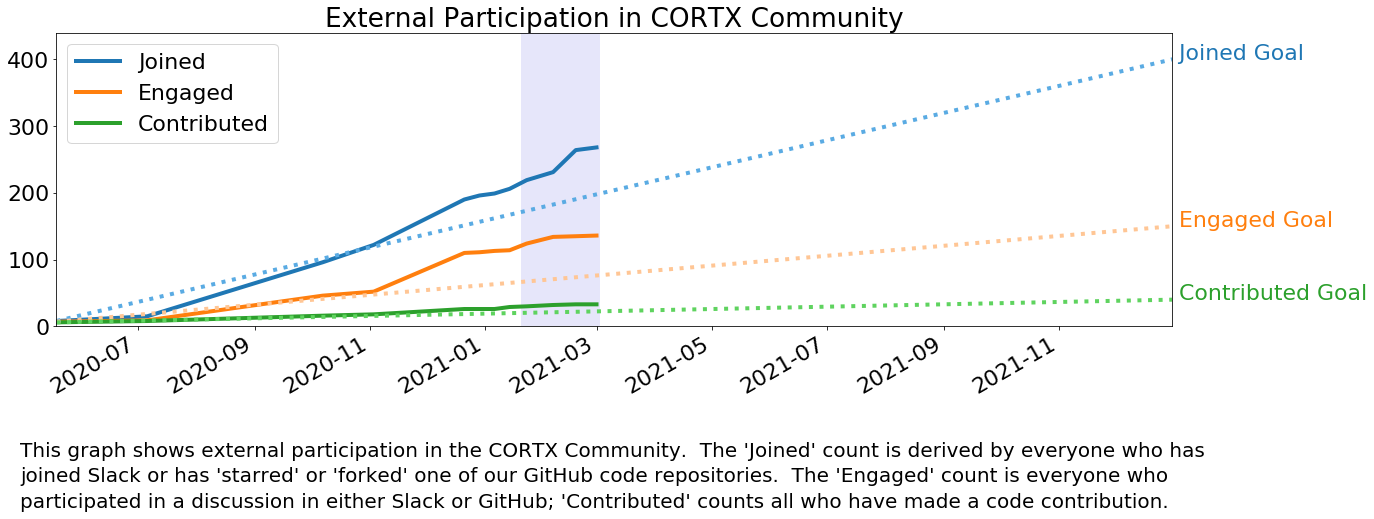

<h3><em><b><center>JOIN ENGAGE CONTRIBUTE are the path to Growth</center></b></em></h3>

In [133]:
# the summary graph
#display(HTML('# BIG TITLE')) # try to add a title
slide_title('CORTX Community Growth at a Glance')
# this is a fragment now but I'd like it to show up immediately with the parent slide.  Not sure how.
html=False # also doesn't work
if html:
    print('p.ex1 {font-size: 30px;}')
    print('<p class="ex1">This is a bigger paragraph.</p>')
    
goal1 = cg.Goal(metric1, goal_date, JOIN_GOAL)
goal2 = cg.Goal(metric2, goal_date, ENGAGE_GOAL)
goal3 = cg.Goal(metric3, goal_date,  CONTRIB_GOAL)
plt = cg.goal_graph(df=df1,title="External Participation in CORTX Community",
                    xlim=xlim,goals=[goal1,goal2,goal3],columns=[metric1,metric2,metric3])
plt.legend(loc='upper left')
add_caption(plt,
    ["This graph shows external participation in the CORTX Community.  The 'Joined' count is derived by everyone who has ",
     "joined Slack or has 'starred' or 'forked' one of our GitHub code repositories.  The 'Engaged' count is everyone who ",
     "participated in a discussion in either Slack or GitHub; 'Contributed' counts all who have made a code contribution."])
plt=add_date_rectangle(plt)
plt.show()

slide_emphasis("JOIN ENGAGE CONTRIBUTE are the path to Growth")

# Categorizing Metrics Across Four Goals

To best realize CORTX’s potential to reduce software costs and allow users to purchase more storage with their data center budgets, CORTX is 100% open source software. To maximize its utility, a vibrant engaged community is essential. This report describes and quantifies multiple goals for CORTX Community to allow us to identify opportunities for improvement so that we can best apply our resources.

CORTX Community goals are divided into four main categories: 

1. **Awareness** 
    * Ensuring that CORTX is well-known and has been visibly marketed across our target customer base
2. **Community Development**
    * Ensuring the community grows by attracting and retaining potential contributors 
3. **Project Development**
    * Ensuring the community can and does contribute to the development of CORTX 
4. **Adoption** 
    * Growing the uptake of software into customer data centers

This report is accordingly split into 4 sections (one for each category). Within each category, we track dozens of metrics but in this report, we focus merely on just a few select metrics for each category which we feel present the most meaningful, yet concise, overview of CORTX Community.

## Awareness

Within Awareness, our topline metrics are as follows: 

1. **Github Visits/Views**
    * This is the count of the biweekly unique visitors to github.
1. **Referrals from Seagate**
    * Of those visitors, this shows how many were referred from seagate.com.
1. **Newsletter Subscriptions** 
    * The number of subscribers to our CORTX Community Monthly Newsletter.
1. **External Joiners**
    * This is the total count of all external people who have joined us in either Slack or GitHub.

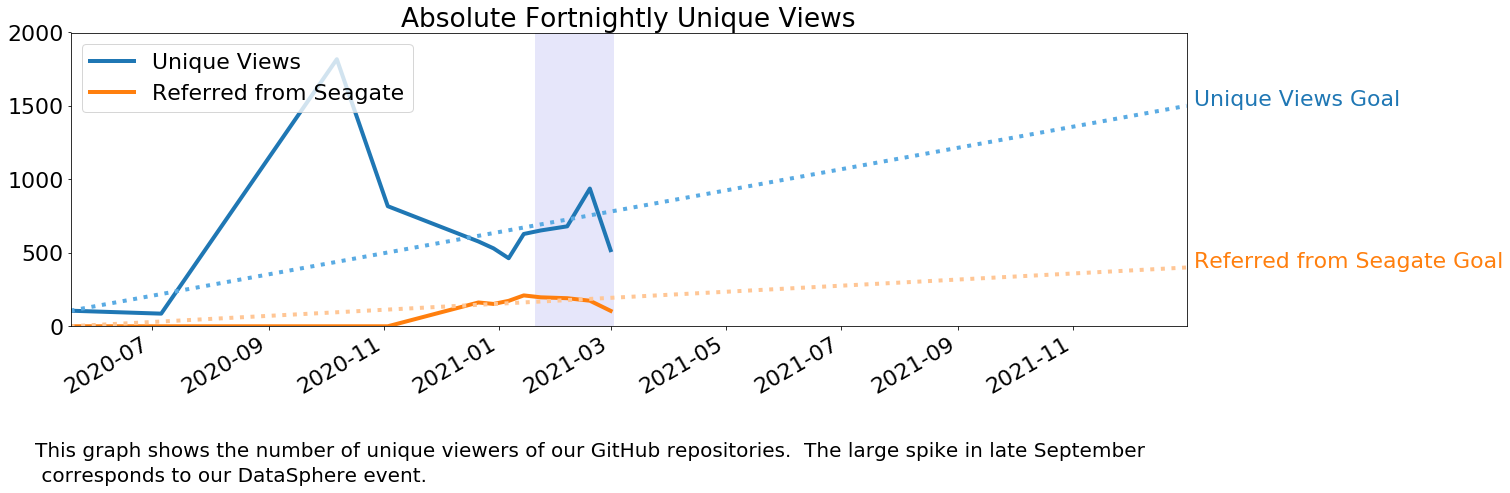

<h3><em><b><center>People are busy and there is large competition for their limited interest.  Can we get them to check out CORTX?</center></b></em></h3>

In [134]:
# make the graph for visits/views and referrals
title='Accumulative Fortnightly Unique Views'
metric1='Accumulated Unique Views'
metric2='Accumulated Referred from Seagate'
metric3="Unique Views"
metric4="Referred from Seagate"
metric5="Max Unique Views"
metric6="Max Referred from Seagate"
df1=remove_overly_frequent(df)
df1[metric1] = df1['views_unique_14_days'].cumsum()
df1[metric2] = df1['seagate_referrer_uniques'].cumsum() + df['seagate_blog_referrer_uniques'].cumsum()
df1[metric3] = df1['views_unique_14_days']
df1[metric4] = df1['seagate_referrer_uniques'] + df['seagate_blog_referrer_uniques']
df1[metric5] = df1['views_unique_14_days'].cummax()
df1[metric6] = df1['seagate_referrer_uniques'].cummax() + df['seagate_blog_referrer_uniques'].cummax()

target_graph='absolute'
if target_graph == 'accumulative':
    goal1 = cg.Goal(metric1, goal_date,15000)
    goal2 = cg.Goal(metric2, goal_date, 3000)
    plt = cg.goal_graph(df=df1,title=title,xlim=xlim,goals=[goal1,goal2],columns=[metric1,metric2])
    plt.legend(loc='upper left')
    plt.show()
elif target_graph == 'absolute':
    goal3 = cg.Goal(metric3, goal_date, 1500)
    goal4 = cg.Goal(metric4, goal_date, 400)
    plt = cg.goal_graph(df=df1,title="Absolute Fortnightly Unique Views",xlim=xlim,goals=[goal3,goal4],columns=[metric3,metric4])
    #plt.gca().add_patch(dave_rectangle)
    plt = add_date_rectangle(plt)
    plt.legend(loc='upper left')
    add_caption(plt,
        ["This graph shows the number of unique viewers of our GitHub repositories.  The large spike in late September",
        " corresponds to our DataSphere event."])
    plt.show()
elif target_graph == 'max':
    goal5 = cg.Goal(metric5, goal_date, 3000)
    goal6 = cg.Goal(metric6, goal_date, 600)
    plt = cg.goal_graph(df=df1,title="Max Fortnightly Unique Views",xlim=xlim,goals=[goal5,goal6],columns=[metric5,metric6])
    plt.legend(loc='upper left')
    plt.show()

slide_emphasis("People are busy and there is large competition for their limited interest.  Can we get them to check out CORTX?")


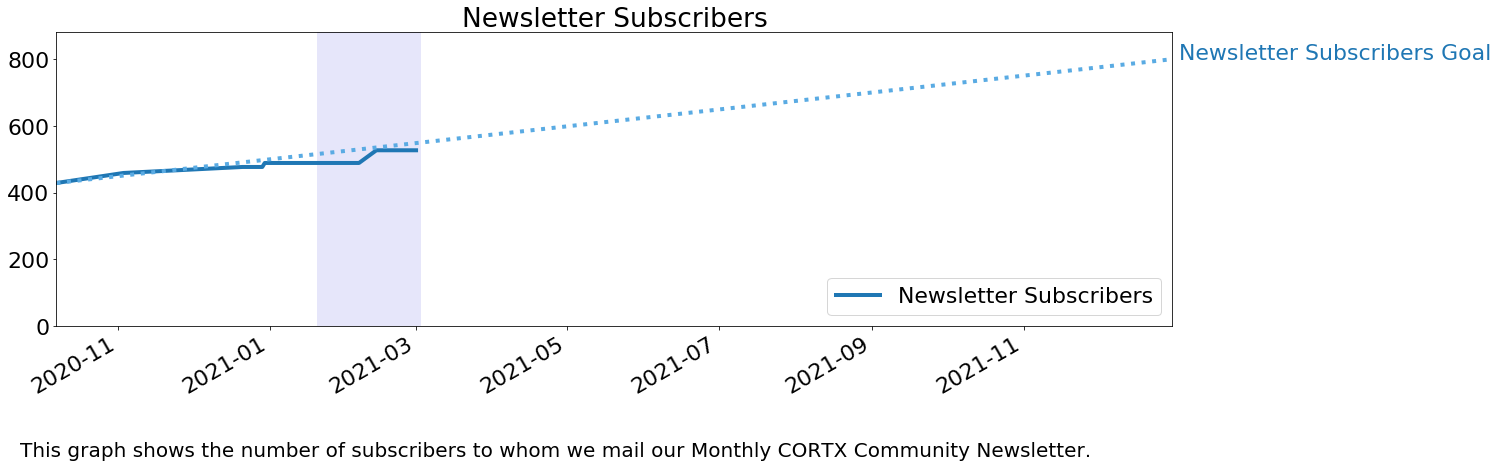

<h3><em><b><center>A great sign of a person's interest is subscribing to our monthly newsletter.</center></b></em></h3>

In [135]:
# make the graph for newsletter subscriptions
news_key='newsletter_subscribers'
metric3=news_key.replace('_',' ').title()

df[metric3] = df[news_key]
goal3 = cg.Goal(metric3, goal_date,800)
plt = cg.goal_graph(df=df,title=metric3,xlim=xlim,goals=[goal3],columns=[metric3])
add_caption(plt,["This graph shows the number of subscribers to whom we mail our Monthly CORTX Community Newsletter."])
plt=add_date_rectangle(plt)
plt.show()
slide_emphasis("A great sign of a person's interest is subscribing to our monthly newsletter.")

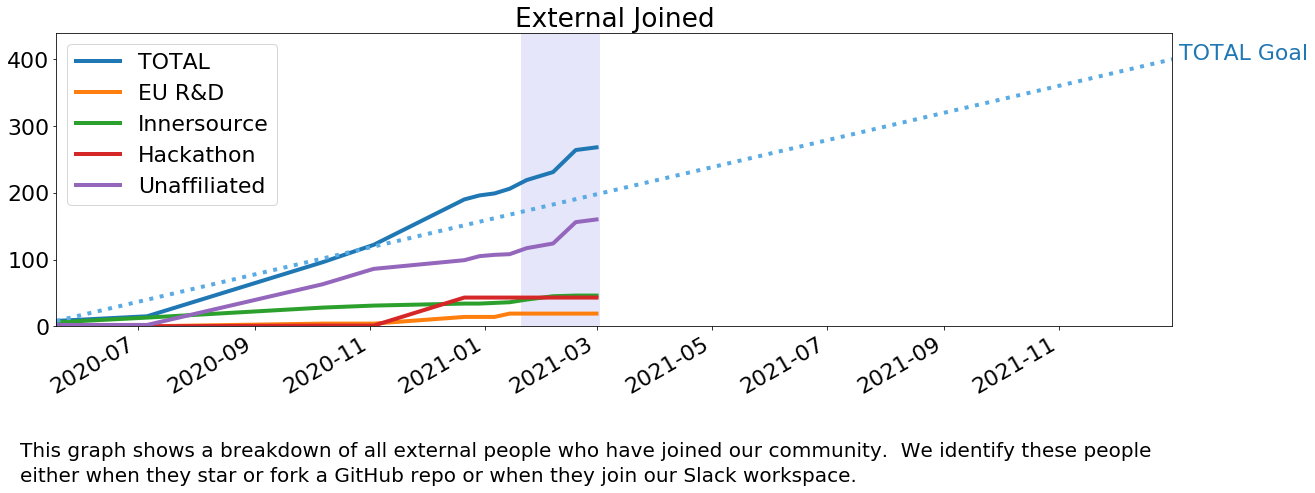

<h3><em><b><center>The large number of unaffiliated joiners indicates a successful global marketing effort.</center></b></em></h3>

In [136]:
caption=["This graph shows a breakdown of all external people who have joined our community.  We identify these people ",
        "either when they star or fork a GitHub repo or when they join our Slack workspace."]
new_df=new_external_graph(external_df,external_data,0,'Joined',JOIN_GOAL,caption=caption,rectangle=True)
slide_emphasis("The large number of unaffiliated joiners indicates a successful global marketing effort.")

## Community Development

Within community development, our topline metrics are as follows:

1. **Slack Total Members**
    * The total number of people in our Slack workspace.
1. **Slack Weekly Participants**
    * The total number of people participating in Slack conversations on a weekly basis.
1. **External Engagers**
    * This graphs show all external people who have participated in conversations in either GitHub or Slack
1. **Webinar Attendance**
    * The number of attendees of our Monthly CORTX Community Meet an Architect webinar

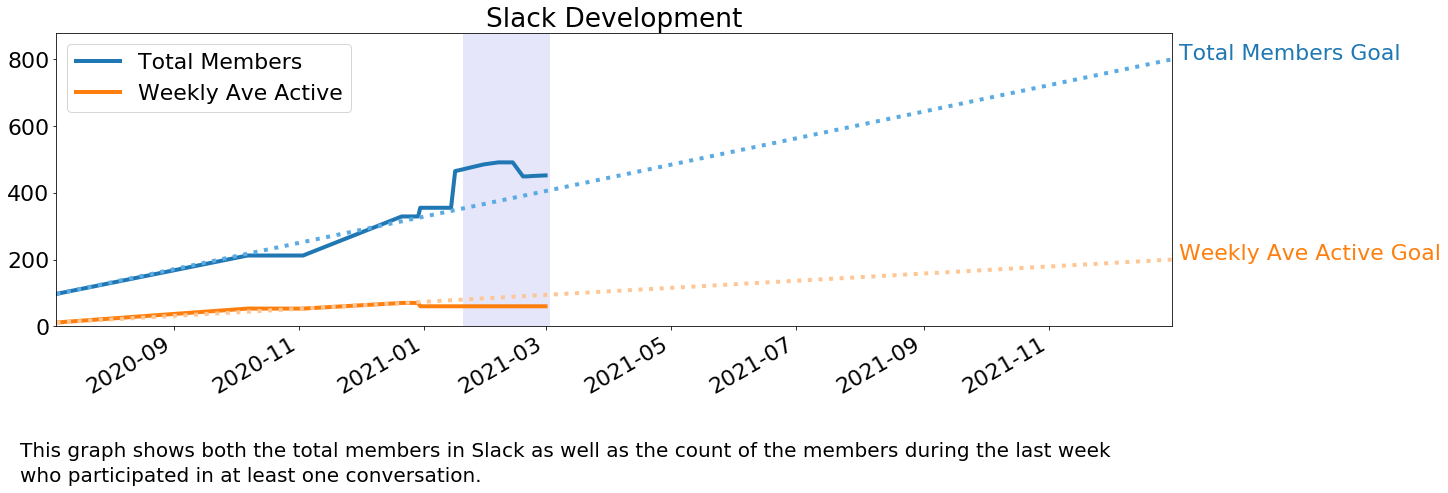

<h3><em><b><center>We are growing our members faster than we are growing our conversations.  This is an area for improvement.</center></b></em></h3>

In [137]:
title='Slack Development'
slack_members_key='slack_total_members'
slack_wau_key='slack_weekly_ave_active'


# now that we started auto-scraping slack, we can merge those values in
# slack_member_count can augment slack_total_members
# slack_weekly_participants can augment slack_weekly_ave_active

members_str=nice_slack_title(slack_members_key)
wau_str=nice_slack_title(slack_wau_key)
df[wau_str]=df[[slack_wau_key,'slack_weekly_participants']].max(axis=1)
df[members_str]=df[[slack_members_key,'slack_member_count']].max(axis=1)
members_goal=cg.Goal(members_str,goal_date,800)
wau_goal=cg.Goal(wau_str,goal_date,200)
plt=cg.goal_graph(df=df,title=title,xlim=xlim,goals=[members_goal,wau_goal],columns=[members_str,wau_str])
plt.legend(loc='upper left')
add_caption(plt,['This graph shows both the total members in Slack as well as the count of the members during the last week',
                'who participated in at least one conversation.'])
plt = add_date_rectangle(plt)
plt.show()
slide_emphasis("We are growing our members faster than we are growing our conversations.  This is an area for improvement.")

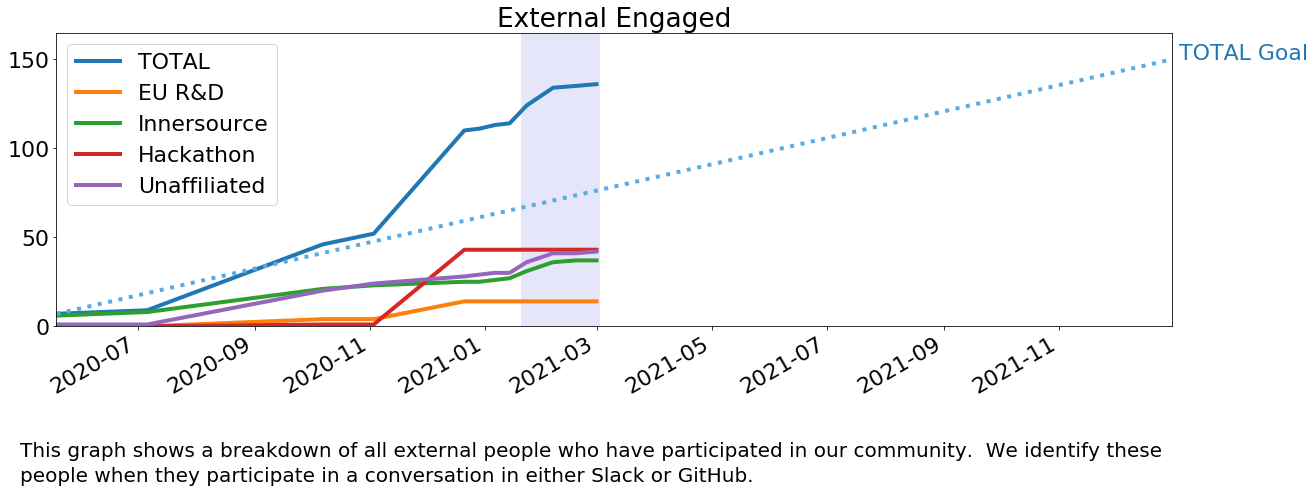

<h3><em><b><center>The unaffiliated join at a greater rate than they engage.</center></b></em></h3>

<h3><em><b><center>Our targeted outreach is better at converting from joiner to engager.</center></b></em></h3>

In [138]:
caption=["This graph shows a breakdown of all external people who have participated in our community.  We identify these ",
        "people when they participate in a conversation in either Slack or GitHub."]
new_df=new_external_graph(external_df,external_data,1,'Engaged', ENGAGE_GOAL,caption=caption,rectangle=True)
slide_emphasis("The unaffiliated join at a greater rate than they engage.")
slide_emphasis("Our targeted outreach is better at converting from joiner to engager.")

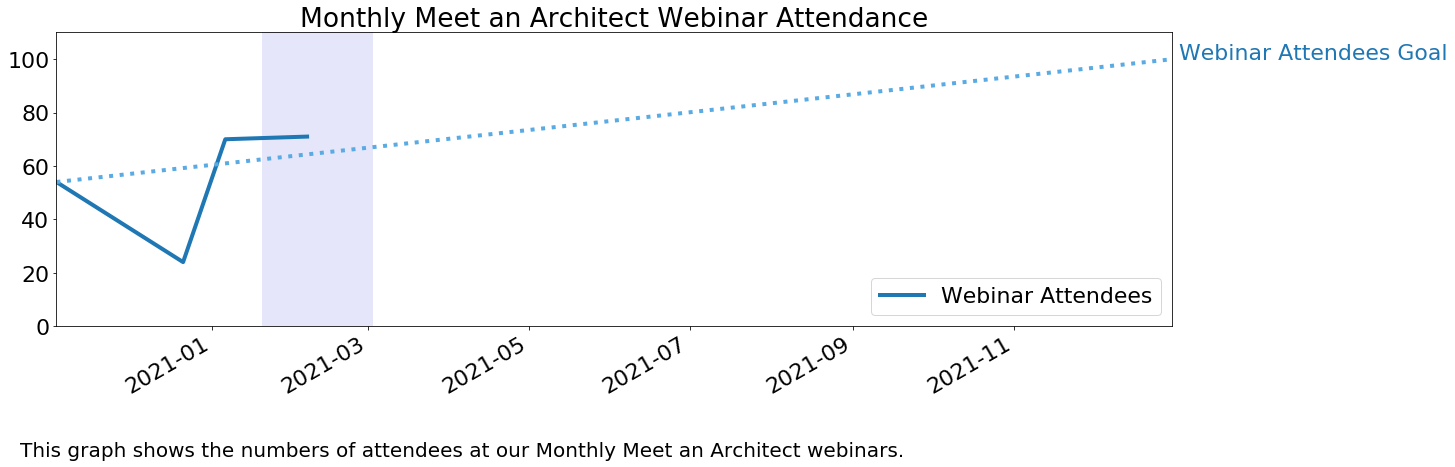

<h3><em><b><center>Attending our architecture deep-dive webinars is a great sign of potential customer interest.</center></b></em></h3>

In [139]:
title='Monthly Meet an Architect Webinar Attendance'
ugly='webinar_attendees'
pretty=nice_slack_title(ugly)
df[pretty]=df[ugly]
df1=df.drop_duplicates(subset=pretty, keep="first")
plt=cg.goal_graph(df=df1,title=title,xlim=xlim,goals=[cg.Goal(pretty,goal_date,100)],columns=[pretty])
add_caption(plt,["This graph shows the numbers of attendees at our Monthly Meet an Architect webinars."])
plt=add_date_rectangle(plt)
plt.show()
slide_emphasis("Attending our architecture deep-dive webinars is a great sign of potential customer interest.")

## Project Development

Within project development, our topline metrics are as follows:

1. **Companies Engaging**
    * The total number of companies that are participating in the CORTX Community.
    * For lists of company domains, please refer to the Appendix.
1. **Acceptance Rate of External PRs**
    * The acceptance rate of contributions from external members.
1. **Total Integrations**
    * The number of external communities with which we have demonstrated interoperability with CORTX.

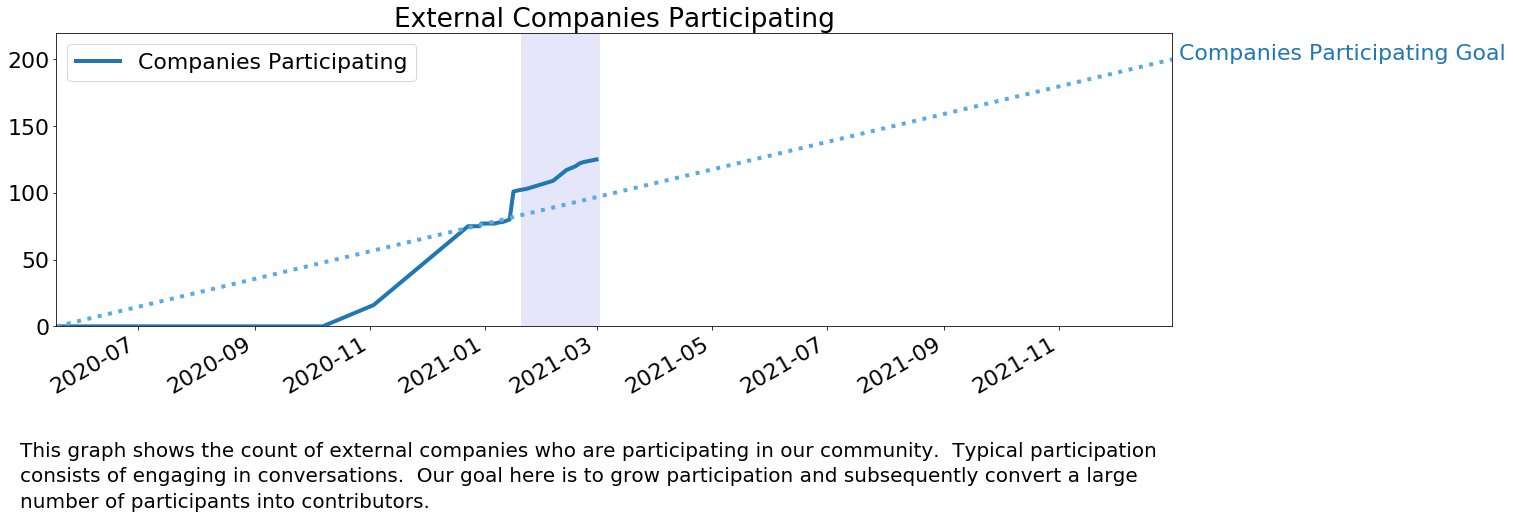

<h3><em><b><center>Individuals are nice but our actual target is companies.</center></b></em></h3>

In [140]:
company_graph(df,'Participating',
    caption=['This graph shows the count of external companies who are participating in our community.  Typical participation',
            'consists of engaging in conversations.  Our goal here is to grow participation and subsequently convert a large',
            'number of participants into contributors.'],
    rectangle=True)
slide_emphasis("Individuals are nice but our actual target is companies.")

<h2><center>External Companies Participating</center></h2>

As of March 03, 2021, 120 company domains participating.  Wordcloud sized by number of members from each.

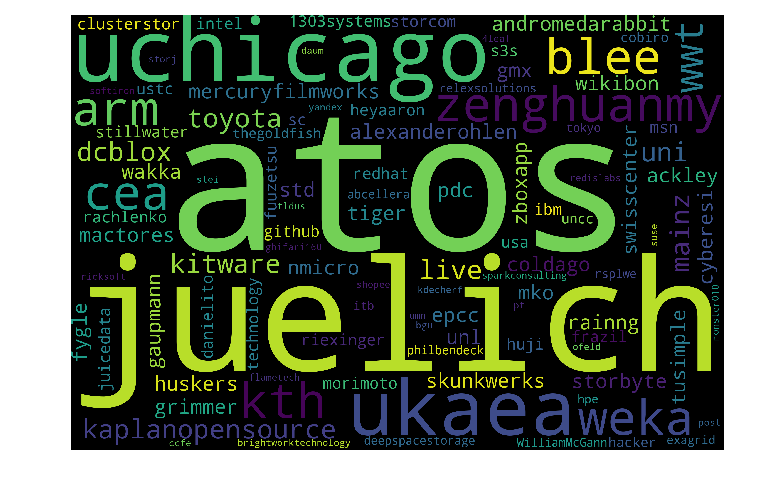

In [141]:
today=datetime.date.today().strftime("%B %d, %Y")
slide_title('External Companies Participating')
display(Markdown("As of %s, %d company domains participating.  Wordcloud sized by number of members from each." 
                 % (today,len(current_domains))))

plot_cloud(wordcloud,caption=None)

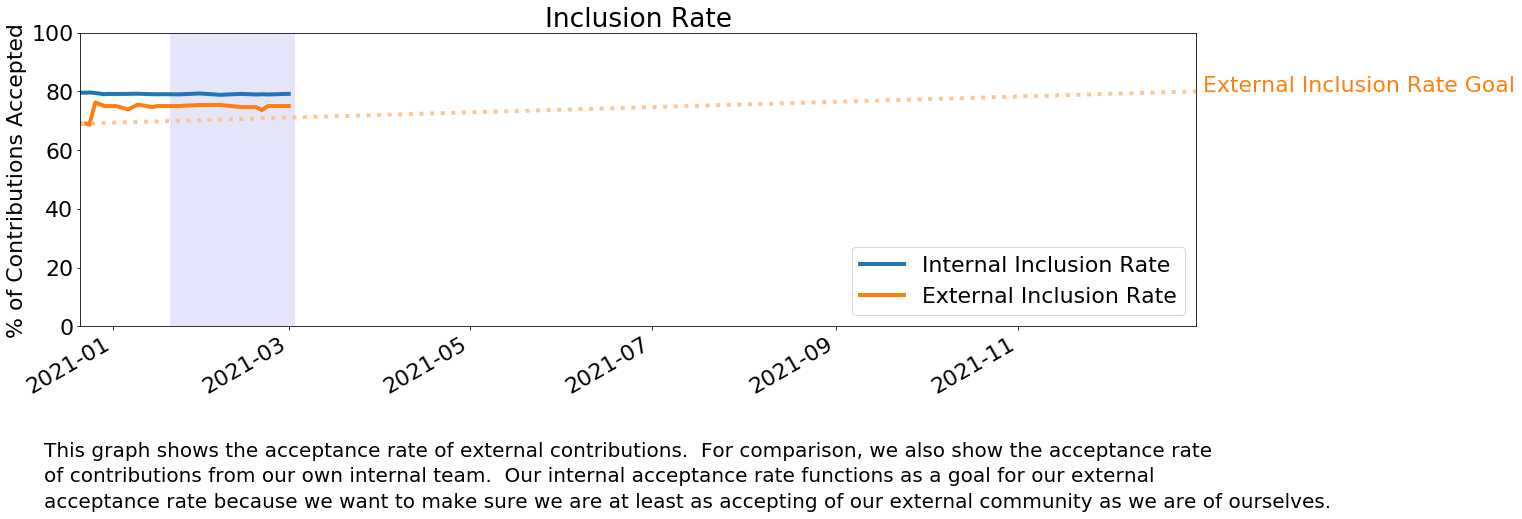

<h3><em><b><center>Ensuring we treat our community with the respect they deserve.</center></b></em></h3>

In [142]:
# Compare merge rate of internal to external
mr='Inclusivity'
mr_columns=[]
for k in ['internal','external']:
    mr_column=('%s Inclusion Rate' % k).title()
    df[mr_column] = 100 * df['pull_requests_%s_merged' % k] / df['pull_requests_%s' % k]
    mr_columns.append(mr_column)
mr_goal=cg.Goal('External Inclusion Rate'.title(),goal_date,80)
title='Inclusion Rate'
plt1=cg.goal_graph(df=df,title=title,xlim=xlim,ylim=(0,100),columns=mr_columns,goals=[None,mr_goal])
caption=['This graph shows the acceptance rate of external contributions.  For comparison, we also show the acceptance rate ',
        'of contributions from our own internal team.  Our internal acceptance rate functions as a goal for our external ',
        'acceptance rate because we want to make sure we are at least as accepting of our external community as we are of ourselves.']
add_caption(plt,caption)
plt1.ylabel("% of Contributions Accepted")
plt1=add_date_rectangle(plt1)
plt1.show()
slide_emphasis('Ensuring we treat our community with the respect they deserve.')

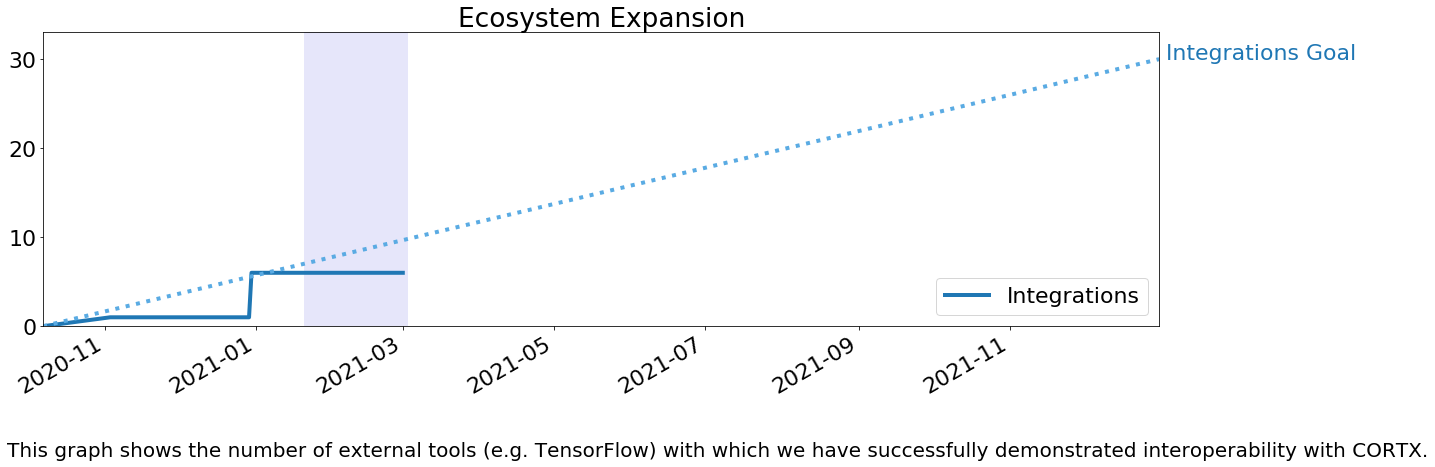

<h3><em><b><center>CORTX is flexible and well-suited for a wide of big data workloads and environments.</center></b></em></h3>

<h3><em><b><center>We are working with our community to prove this.</center></b></em></h3>

In [143]:
key='integrations'
title=key.title()
df[title]=df[key]
goal=cg.Goal(title,goal_date,30)
plt2=cg.goal_graph(df=df,title='Ecosystem Expansion',xlim=xlim,goals=[goal],columns=[title])
add_caption(plt2,['This graph shows the number of external tools (e.g. TensorFlow) with which we have successfully demonstrated interoperability with CORTX.'])
plt2=add_date_rectangle(plt2)
plt2.show()
slide_emphasis('CORTX is flexible and well-suited for a wide of big data workloads and environments.')
slide_emphasis('We are working with our community to prove this.')

## Adoption

Within adoption, our topline metrics are as follows:

1. **Pre-Built Software Downloads**
    * The number of times that people have downloaded the pre-built CORTX software.
    * Measuring whether people are using the easy path to adoption that we provide.
1. **External Contributors**
    * The number of external community members contributing to CORTX.
1. **External Companies**
    * The number of external companies who are contributing to CORTX.
    * For a list of company domains, please refer to the Appendix.


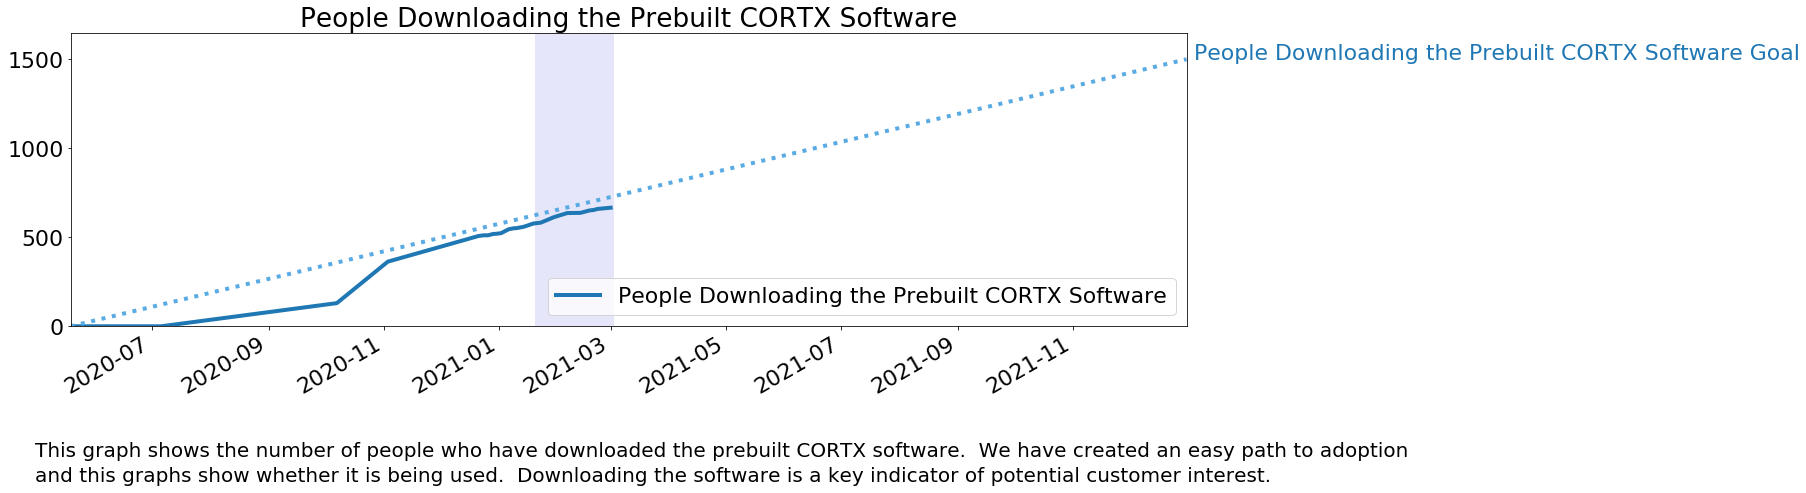

<h3><em><b><center>Typical downloads are people evaluating CORTX suitability for their environment and workloads.</center></b></em></h3>

In [144]:
title='People Downloading the Prebuilt CORTX Software'
df[title] = df['downloads_vms']
plt=cg.goal_graph(df=df,title=title,xlim=xlim,goals=[cg.Goal(title,goal_date,1500)],columns=[title])
add_caption(plt,
    ['This graph shows the number of people who have downloaded the prebuilt CORTX software.  We have created an easy path to adoption',
    'and this graphs show whether it is being used.  Downloading the software is a key indicator of potential customer interest.'])
plt=add_date_rectangle(plt)
plt.show()
slide_emphasis('Typical downloads are people evaluating CORTX suitability for their environment and workloads.')

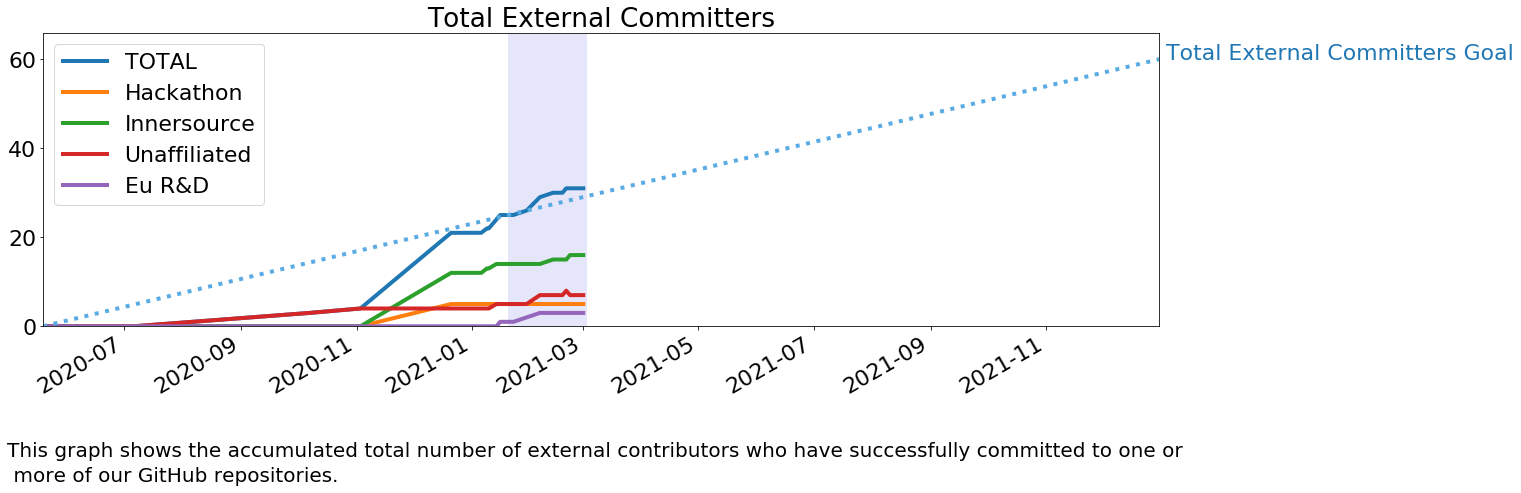

<h3><em><b><center>Nothing is more satisfying to our community team than mentoring a visitor into a contributor.</center></b></em></h3>

<h3><em><b><center>Nothing is more satisfying to our product management than knowing what our community cares about.</center></b></em></h3>

<h3><em><b><center>Nothing is more satisfying to our sales team than identifying people with such a deep engagement.</center></b></em></h3>

In [145]:
caption=["This graph shows the accumulated total number of external contributors who have successfully committed to one or",
        " more of our GitHub repositories."]
external_graph('committers',60,caption=caption,rectangle=True)
slide_emphasis('Nothing is more satisfying to our community team than mentoring a visitor into a contributor.')
slide_emphasis('Nothing is more satisfying to our product management than knowing what our community cares about.')
slide_emphasis('Nothing is more satisfying to our sales team than identifying people with such a deep engagement.')

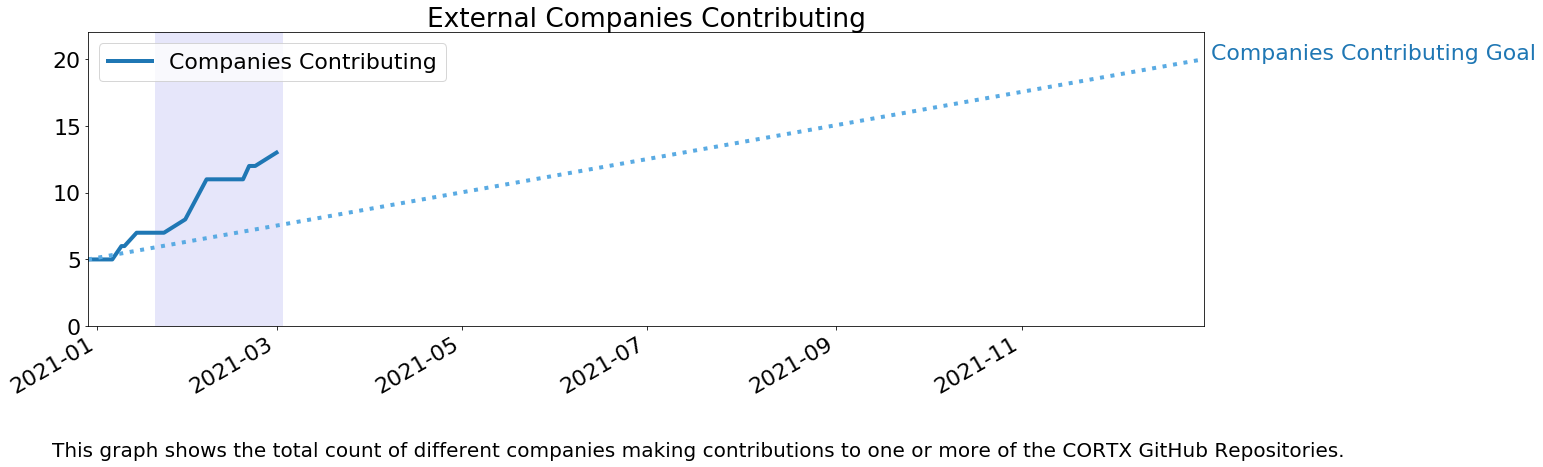

<h3><em><b><center>Individuals are nice but companies are the actual sales targets.</center></b></em></h3>

In [146]:
caption=['This graph shows the total count of different companies making contributions to one or more of the CORTX GitHub Repositories.']
company_graph(df,'Contributing',caption=caption,rectangle=True)
slide_emphasis("Individuals are nice but companies are the actual sales targets.")

## Conclusion

Thanks for checking out our CORTX Community Executive report!  As always, we are very happy to receive any and all feedback.
We can easily be reached using any of the following methods:
    
1. __Email__ : cortx-questions@seagate.com
2. __Slack__ : https://cortx.link/join-slack
3. __Github Discussions__ : https://github.com/Seagate/cortx/discussions
4. __Github Issues__ : https://github.com/Seagate/cortx/issues

        
We look forward to hearing from you.  For detailed lists of all external companies engaged in our CORTX Community, please refer to the Appendix below. Please also refer to the Appendix for some comparisons of CORTX Community growth relative to other comparable open source projects.


## APPENDIX

Our appendix currently contains two main items.
1. **Fork and Star Comparison**
    * This graphs compare CORTX to other open source object storage systems using GitHub Stars and Forks
2. **Company Domains Discovered**
    * This section lists all of the company domains which we have discovered this far in CORTX
    * It also lists the ones which entered the community during the previous month

### Fork and Star Comparison

The following two graphs compare CORTX to comparable open source object storage systems being developed by other companies using GitHub Stars and GitHub Forks.  Both graphs are normalized to the earliest year of data available for each system.  For
most of the systems shown, this normalizes to "Day Zero" for when the project was added to GitHub.  Note that Ceph and Swift however have been around for so long that their "Day Zero" is not available and thus the data for those two actually starts about half-way through their respective lifespans.

In [147]:
sf_data=cc.ProjectComparisons().get_stats()
star_data=sf_data['stars']
fork_data=sf_data['forks']

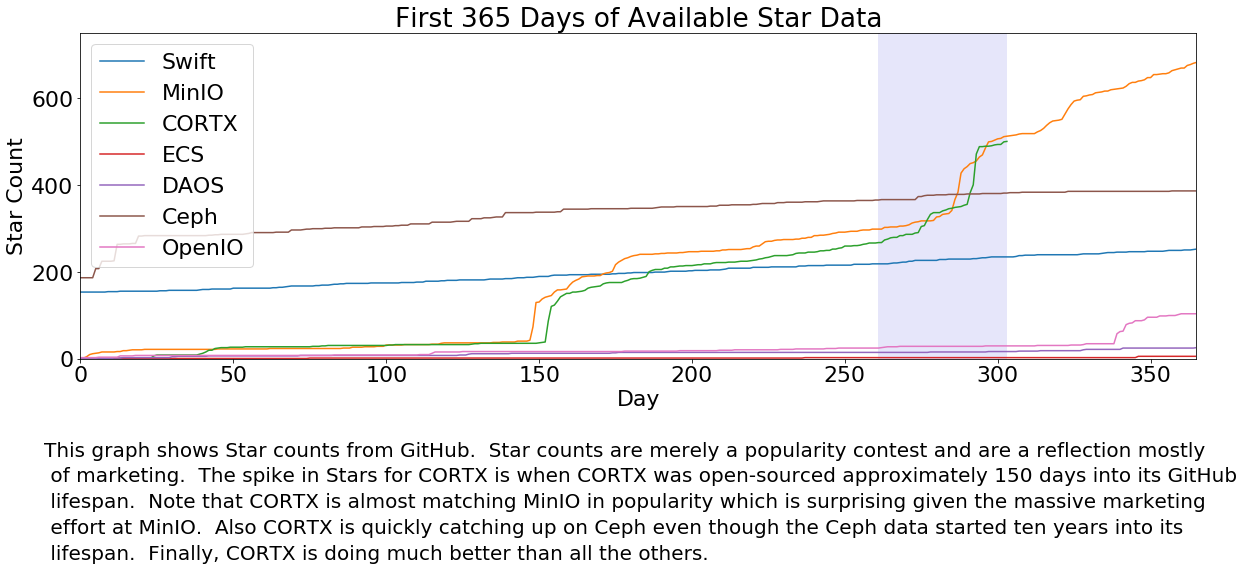

<h3><em><b><center>Doing very well in our first 365 days but marketing efforts would be useful to catch up a bit faster.</center></b></em></h3>

In [148]:
# star graphs
df=get_sf_dataframe(star_data)
caption=['This graph shows Star counts from GitHub.  Star counts are merely a popularity contest and are a reflection mostly',
        ' of marketing.  The spike in Stars for CORTX is when CORTX was open-sourced approximately 150 days into its GitHub',
        ' lifespan.  Note that CORTX is almost matching MinIO in popularity which is surprising given the massive marketing',
        ' effort at MinIO.  Also CORTX is quickly catching up on Ceph even though the Ceph data started ten years into its',
        ' lifespan.  Finally, CORTX is doing much better than all the others.']
make_sf_graph(df=df,data=star_data,end_day=365,title="First 365 Days of Available",what='Star',caption=caption,rectangle=True)
slide_emphasis("Doing very well in our first 365 days but marketing efforts would be useful to catch up a bit faster.")

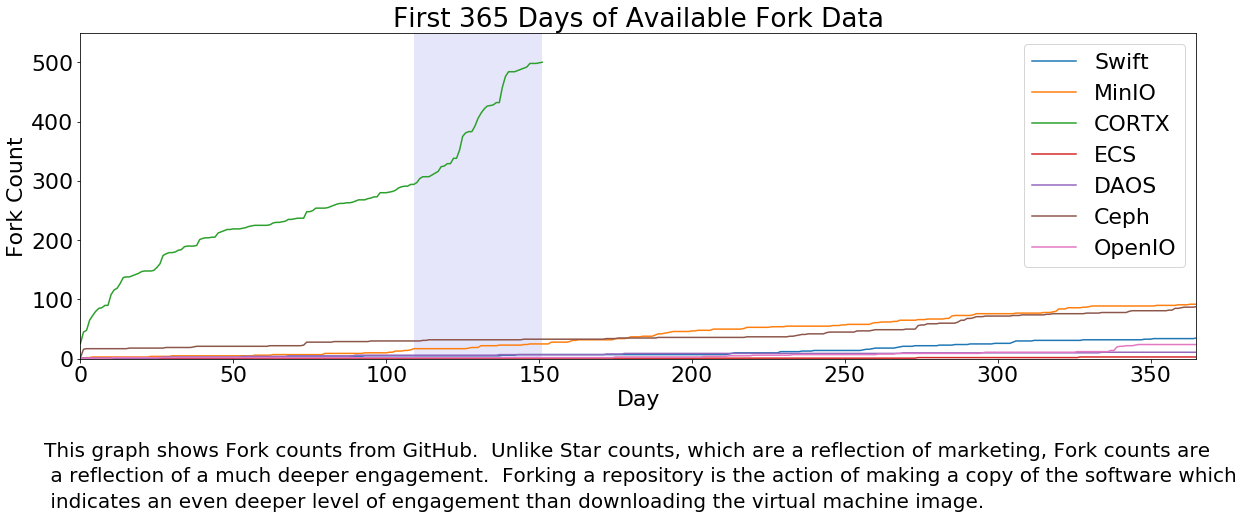

<h3><em><b><center>This metric reveals a tremendous and unrivaled deep level of engagement with CORTX.</center></b></em></h3>

In [149]:
# fork graphs
df=get_sf_dataframe(fork_data)
caption=['This graph shows Fork counts from GitHub.  Unlike Star counts, which are a reflection of marketing, Fork counts are',
        ' a reflection of a much deeper engagement.  Forking a repository is the action of making a copy of the software which',
        ' indicates an even deeper level of engagement than downloading the virtual machine image.']
make_sf_graph(df=df,data=fork_data,end_day=365,title="First 365 Days of Available",what='Fork',caption=caption,rectangle=True)
slide_emphasis("This metric reveals a tremendous and unrivaled deep level of engagement with CORTX.")

### Company Adoption

One of the things we are actively tracking in our community is the external companies engaging.  This data is automatically scraped from email addresses associated with GitHub and Slack participants.

As of March 03, 2021, we have 120 domains currently engaged which is 14 more than we had one month ago.

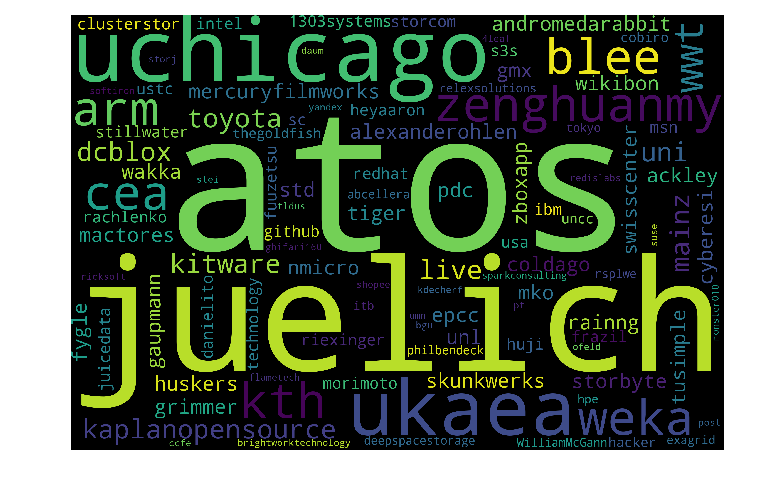

In [150]:
(current_domains,new_domains,all_domains)=get_domains(ps)    
display(Markdown("As of %s, we have %d domains currently engaged which is %d more than we had one month ago." 
                 % (today,len(current_domains),len(new_domains))))

plot_cloud(wordcloud)

In [151]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def show_list(l,intro):
    display(Markdown(intro))
    domain_chunks=chunks(sorted(list(l),key=lambda s: s.lower()),5)
    for c in domain_chunks:
        display(Pretty(pformat(c)))      

show_list(new_domains,"The following list shows the **%d domains newly discovered** this month:" % len(new_domains))

The following list shows the **14 domains newly discovered** this month:

['1303systems.com',
 'alexanderohlen.se',
 'cobiro.com',
 'exagrid.com',
 'ghifari160.com']

['huskers.unl.edu', 'intel.com', 'mail.com', 'mercuryfilmworks.com', 'msn.com']

['ricksoft.jp', 'storj.io', 'swisscenter.com', 'thegoldfish.org']

In [152]:
show_list(current_domains, "The following list shows **all %d domains every discovered:**" % len(current_domains))

The following list shows **all 120 domains every discovered:**

['.service', '0x7200000000000001', '126.com', '1303systems.com', '163.com']

['4leaf.me',
 'abcellera.com',
 'ackley.net',
 'alexanderohlen.se',
 'andromedarabbit.net']

['arm.com',
 'atos.net',
 'blee.pro',
 'brightworktechnology.com',
 'calsoftinc.com']

['ccfe.ac.uk',
 'cea.fr',
 'centos8.linuxvmimages.local',
 'cobiro.com',
 'coldago.com']

['cyberesi.com',
 'danielito.org',
 'daum.net',
 'dcblox.com',
 'deepspacestorage.com']

['email.com', 'entry', 'epcc.ed.ac.uk', 'exagrid.com', 'flametech.com.au']

['frazil.me', 'fygle.eu', 'fz-juelich.de', 'gamil.com', 'gaupmann.net']

['ghifari160.com',
 'gmail.com',
 'gmail.com, dominic097',
 'gmx.net',
 'grimmer.com']

['hacker.ch',
 'hare81447-test-pcs-pod-c1',
 'heyaaron.com',
 'hotmail.com',
 'hpe.com']

['huskers.unl.edu', 'ibm.com', 'icloud.com', 'intel.com', 'juicedata.io']

['kaplanopensource.co.il', 'kdecherf.com', 'kitware.com', 'kth.se', 'live.cn']

['live.com', 'mactores.com', 'mail.com', 'mail.huji.ac.il', 'mail.toyota.co.jp']

['mercuryfilmworks.com', 'mko.io', 'monster010.de', 'morimoto.io', 'msn.com']

['msystechnologies.com',
 'nmicro.com.tw',
 'o2ib',
 'outlook.co.id',
 'outlook.com']

['outlook.fr', 'outlook.in', 'pdc.kth.se', 'philbendeck.com', 'pm.me']

['pod-c1', 'post.bgu.ac.il', 'pt.lu', 'rachlenko.com', 'rainng.com']

['redhat.com',
 'redislabs.com',
 'relexsolutions.com',
 'ricksoft.jp',
 'riexinger-ofeld.de']

['rsplwe.com', 's3s-usa.com', 'services', 'shopee.com', 'skunkwerks.at']

['softiron.com',
 'sparkconsulting.io',
 'std.stei.itb.ac.id',
 'stillwater-sc.com',
 'storbyte.com']

['storcom.net', 'storj.io', 'suse.com', 'swisscenter.com', 'tcp']

['thegoldfish.org',
 'tiger-technology.com',
 'tldus.com',
 'toyota-tokyo.tech',
 'tusimple.ai']

['uchicago.edu', 'ukaea.uk', 'umn.edu', 'uni-mainz.de', 'ustc.edu.cn']

['wakka.tv', 'walla.com', 'weka.io', 'wikibon.org', 'WilliamMcGann.com']

['wwt.com', 'yahoo.co.uk', 'yahoo.com', 'zboxapp.com', 'zenghuanmy.com']